# Инициализация 

In [2]:
#importing part

import numpy as np
import tt
from tt.optimize import tt_min
from tt.eigb import *

from scipy import optimize as opt
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [3]:
def J_gen(L,j1,j2):
    J = np.zeros((L*L, L*L))
    for i in range(L):
        for j in range(L):
            J[i * L + j, i * L + ((j + 1) % L)] = j1
            J[i * L + j, ((i + 1) % L) * L + j] = j1
            J[i * L + j, ((i + 1) % L) * L + ((j + 1) % L)] = j2
            J[i * L + j, ((i + 1) % L) * L + ((j - 1) % L)] = j2
    J = 0.5 * (J + J.T)
    return J

def H_gen(J):
    def H_f(n):
        a = []
        for m in n:
            m = int(m)
            s = np.array([(m // 2**i) % 2 for i in range(N)]) - 0.5 * np.ones(N)
            a.append(-1 * (s.T @ J @ s))
        return a

    N = J.shape[0]
    x = tt.xfun(n = 2, d = N)
    H = tt.multifuncrs([x], H_f, 1e-12, y0 = tt.rand(n = 2, d = N), verb = 0, rmax = 15)
    H = tt.diag(H)
    return(H)

def X_gen(n):
    head = np.zeros((1,2,2,2))
    head[0,0,0,0] = 1
    head[0,1,1,0] = 1
    head[0,1,0,1] = 1
    head[0,0,1,1] = 1

    body = np.zeros((2,2,2,2))
    body[0,0,0,0] = 1
    body[0,1,1,0] = 1
    body[0,0,1,1] = 1
    body[0,1,0,1] = 1
    body[1,0,0,1] = 1
    body[1,1,1,1] = 1

    tail = np.zeros((2,2,2,1))
    tail[0,1,0,0] = 1
    tail[0,0,1,0] = 1
    tail[1,0,0,0] = 1
    tail[1,1,1,0] = 1

    a = [head]
    for i in range(n-2):
        a.append(body)
    a.append(tail)
    result = tt.matrix.from_list(a)
    return result

def project_gen(state, symmetry = False):
    a = tt.vector.to_list(state)
    b = []
    c = []
    for x in a:
        shape = x.shape
        b.append(x.reshape(shape[0],shape[1],-1,shape[2]))
        c.append((x[:,::-1,:]).reshape(shape[0],shape[1],-1,shape[2]))
    M1 = tt.matrix.from_list(b)
    M2 = tt.matrix.from_list(c)
    if symmetry:
        return M1 @ M1.T + M2 @ M2.T
    return M1 @ M1.T


# Рассчет Энергии Основного Состояния


## Через D-WAVE 

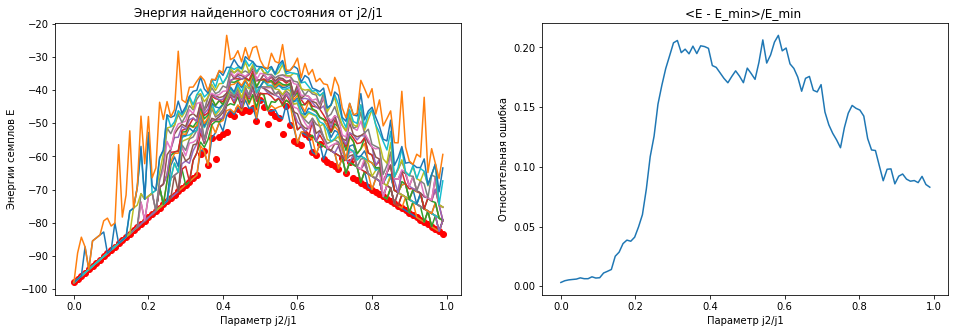

In [4]:
energy_dwave = np.load('dwave-data_energy.npy')
polarisation_dwave = np.load('dwave-data_polarization.npy')

N = energy_dwave.shape[1]
M = energy_dwave.shape[0]
K = 5

fig = plt.figure(figsize=(16.,5.))
sbplt = plt.subplot(1, 2, 1)
sbplt.set_title('Энергия найденного состояния от j2/j1')
sbplt.set_ylabel('Энергии семплов E')
sbplt.set_xlabel('Параметр j2/j1')

plt.scatter((1 / N) * np.array(range(N)), energy_dwave[0], color = 'red')
for x in energy_dwave[1:]:
    plt.plot((1 / N) * np.array(range(N)), x)
sbplt = plt.subplot(1, 2, 2)
sbplt.set_title('<E - E_min>/E_min ')
sbplt.set_ylabel('Относительная ошибка')
sbplt.set_xlabel('Параметр j2/j1')
plt.plot( (1 / (N - K + 1)) * np.array(range(N - K + 1)), np.convolve((energy_dwave[0] - sum(energy_dwave)/M)/energy_dwave[0] , np.ones(K)/K, mode='valid'))
plt.show()

## Через CROSSOPT

In [5]:
def Q_gen(L,j1,j2):
    J = -1 * J_gen(L,j1,j2)
    Q = np.zeros(L ** 2)
    for p in range(L ** 2):
        Q[p] = - 2 * (sum(J[:, p]) + sum(J[p, :]))
    Q = 4 * J + np.diag(Q)
    shift = sum(sum(J))
    return Q, shift

def get_data_cross(L, Kappa, N, rmax = 10, nswp = 20):
    def my_function(Q, shift, x):
        n = Q.shape[0]
        if(len(x.shape) == 1):
            return x.T @ Q @ x + shift
        a = []
        for y in x:
            energy = y.T @ Q @ y + shift
            a.append(energy)
        return np.array(a)
    energy_cross = []
    for i in range(N):
        j1 = 1
        j2 = -1 * Kappa * (i / N)
        Q, shift = Q_gen(L,j1,j2)
        function = lambda x: my_function(Q, shift, x)
        energy = tt_min.min_func(function, 0, 1, d = L * L, n0 = 2, rmax=rmax, nswp=nswp, verb = False)[0]
        energy_cross.append(energy)
        if( (i+1) % (10) == 0): print((i+1), "/", N)
    return np.array(energy_cross)

In [6]:
N = 100
energy_cross  = get_data_cross(L = 7, Kappa = 1, N = N, nswp = 20)

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


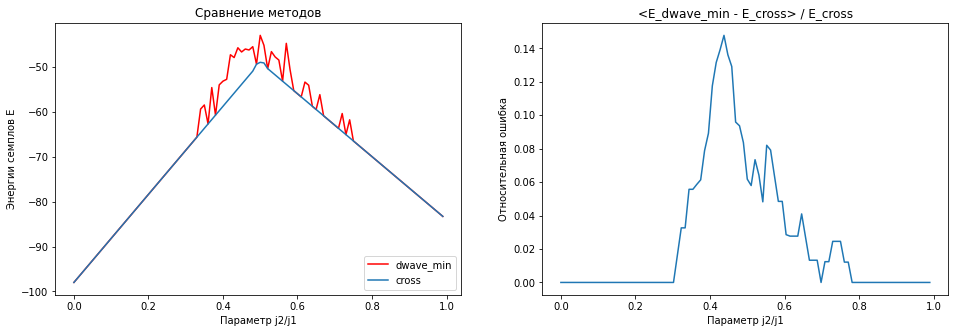

In [7]:
N = 100
K = 5

fig = plt.figure(figsize=(16.,5.))
sbplt = plt.subplot(1, 2, 1)
sbplt.set_title('Сравнение методов')
sbplt.set_ylabel('Энергии семплов E')
sbplt.set_xlabel('Параметр j2/j1')

plt.plot((1 / N) * np.array(range(N)), energy_dwave[0], color = 'red', label = 'dwave_min')
plt.plot((1 / N) * np.array(range(N)), energy_cross, label = 'cross')
sbplt.legend(loc = 'lower right')

sbplt = plt.subplot(1, 2, 2)
sbplt.set_title('<E_dwave_min - E_cross> / E_cross')
sbplt.set_ylabel('Относительная ошибка')
sbplt.set_xlabel('Параметр j2/j1')

plt.plot( (1 / (N - K + 1)) * np.array(range(N - K + 1)), np.convolve((energy_cross - energy_dwave[0])/energy_cross , np.ones(K)/K, mode='valid'))
plt.show()

# Уровни энергии при отжиге

## Через ALS

In [65]:
def clasterization(array, eps):
    N = array.shape[0]
    X = np.array([(1/N) * np.array(range(N)), array]).T
    clusteringX = DBSCAN(eps = eps, min_samples=2).fit(X)
    b = []
    for i in range(N):
        if(clusteringX.labels_[i] == 0):
            b.append(X[i])
    return ((np.array(b).T)[0], (np.array(b).T)[1])

def get_data_annealing_als(L, Kappa, Field, N, M, symmetry = False):
    j1 = 1 
    j2 = -1 * Kappa

    H_x = X_gen(L*L)
    J = J_gen(L, j1, j2)
    H = H_gen(J)
    
    a = []
    for i in range(N):
        Field = 1 * (1 - (i + 1) / N)
        b = []
        H_proj = 0 * project_gen(tt.rand(n = 2, d = L * L, r = 2))

        for j in range(M):
            x = tt.rand(n = 2, d = L * L, r = 2)
            y, lam = eigb(H + Field * H_x + 100 * H_proj, x, 1e-14,verb = 0)
            H_proj = H_proj + project_gen(y, symmetry = symmetry)
            b.append(float(lam))
        a.append(np.sort(b))
        if( (i+1) % (10) == 0): print((i+1), "/", N)
    a = np.array(a).T
    return a

In [71]:
N = 100
M = 3
Max_Field = 0.6
Kappa = 0.425

als_1 = get_data_annealing_als(L = 7, Kappa = Kappa, Field = Max_Field, N = N, M = M)
als_2 = get_data_annealing_als(L = 7, Kappa = Kappa, Field = Max_Field, N = N, M = M)
als_3 = get_data_annealing_als(L = 7, Kappa = Kappa, Field = Max_Field, N = N, M = M)
als_4 = get_data_annealing_als(L = 7, Kappa = Kappa, Field = Max_Field, N = N, M = M)
als_5 = get_data_annealing_als(L = 7, Kappa = Kappa, Field = Max_Field, N = N, M = M)
energy_annealing_als = np.minimum(als_1, als_2)

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


In [73]:
energy_annealing_als = als_1
energy_annealing_als = np.minimum(energy_annealing_als, als_2)
energy_annealing_als = np.minimum(energy_annealing_als, als_3)
energy_annealing_als = np.minimum(energy_annealing_als, als_4)
energy_annealing_als = np.minimum(energy_annealing_als, als_5)

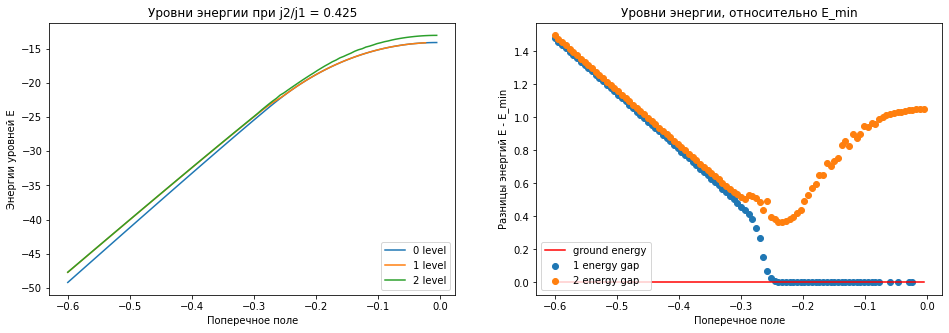

In [91]:
K = 1

fig = plt.figure(figsize=(16.,5.))
sbplt = plt.subplot(1, 2, 1)
sbplt.set_title('Уровни энергии при j2/j1 = ' + str(Kappa))
sbplt.set_ylabel('Энергии уровней E')
sbplt.set_xlabel('Поперечное поле')

for i in range(M):
    array = np.convolve(energy_annealing_als[i], np.ones(K)/K, mode='valid')
    b = clasterization(array = array, eps = 0.5)
    plt.plot(Max_Field * (b[0] - 1),b[1], label = str(i) + " level") 
sbplt.legend(loc = 'lower right')

sbplt = plt.subplot(1, 2, 2)
sbplt.set_title('Уровни энергии, относительно E_min')
sbplt.set_ylabel('Разницы энергий E - E_min')
sbplt.set_xlabel('Поперечное поле')
for i in range(1, M):
    b = clasterization(array = energy_annealing_als[i] - energy_annealing_als[0], eps = 0.15)
    plt.scatter(Max_Field * (b[0] - 1),b[1], label = str(i) + " energy gap" )
plt.plot(Max_Field * (b[0] - 1), 0 * Max_Field * (b[0] - 1), color = 'red', label = "ground energy" )
sbplt.legend(loc = 'lower left')

plt.show()